In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import seaborn as sn

import matplotlib.animation as animation
from scipy.ndimage.filters import gaussian_filter

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor


## Map utils

In [4]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111



In [5]:
FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

## Entreno el modelo que vamos a usar para predecir

In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [8]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

In [9]:
random_predictor = RandomPredictor()
random_predictor.fit(regre_data, regre_target)

## Levanto el chekpoint en pandas

In [10]:
birds_data = pd.read_parquet('tmp/checkpoint-cog.parquet')

In [22]:
MIN_PREDICTIONS = 100
def get_heatmap(birds_data, bird_tag_id):
    birds_data = birds_data[(birds_data.tag_id == bird_tag_id)]
    birds_data = birds_data.drop(columns=['tag_id','timestamp'])
    if len(birds_data) < MIN_PREDICTIONS:
        return None
    predictions = predictor.predict(birds_data)
    
    map_range = np.array([[0,x_f-x_0],[0,y_f-y_0]])
    heatmap, _, _ = np.histogram2d(predictions[:,1], predictions[:,0], bins=(64,64), range=map_range)
    #heatmap = gaussian_filter(heatmap, sigma=2, mode='nearest')
    heatmap = gaussian_filter(heatmap, sigma=2, mode='constant', cval=0.0)
    predictions_count = sum(sum(heatmap))
    if predictions_count > 0:
        heatmap = heatmap/predictions_count
    return heatmap



In [13]:
def get_heatmap_similarity(birds_data):
    heatmap_by_bird = {}
    for bird in FEMALES+MALES:
        heatmap_by_bird[bird] = get_heatmap(birds_data, bird)

    similarity_matrix = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        similarity_matrix[i] = []
        for j in range(len(MALES)):
            female = FEMALES[i]
            male = MALES[j]
            if heatmap_by_bird[female] is None or heatmap_by_bird[male] is None:
                similarity_matrix[i].append(np.nan)      
            else:
                similarity = sum(sum(np.abs(heatmap_by_bird[female]-heatmap_by_bird[male]))) ## de esta forma, el valor de similaridad va a estar entro 0 y 2. Seguramente el valor 0 sea porque no tuvo emisiones. Habria que sacar eso
                similarity = similarity*50 ## para que este entre 0 y 100
                similarity_matrix[i].append(similarity)      
    return similarity_matrix



In [14]:
def show_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(9,5))

    plt.subplot(1, 1, 1)
    plt.title('Birds heatmap similarity')
    similarity_matrix_pd = pd.DataFrame(similarity_matrix)
    similarity_matrix_pd.columns = MALES
    similarity_matrix_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    similarity_matrix_pd = similarity_matrix_pd.round(2)
    ax = sn.heatmap(similarity_matrix_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
    ax.set(xlabel='Males', ylabel='Females')
    
    '''
    plt.subplot(3, 1, 2)
    plt.title('Male similarity distribution')
    matrix_res_pd = pd.DataFrame(similarity_matrix)
    similarity_matrix_pd.columns = MALES
    similarity_matrix_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    similarity_matrix_pd = (similarity_matrix_pd/similarity_matrix_pd.sum()*100).round(2)
    similarity_matrix_pd = similarity_matrix_pd.fillna(0)
    ax = sn.heatmap(similarity_matrix_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')


    plt.subplot(3, 1, 3)
    plt.title('Female similarity distribution')
    similarity_matrix_pd = pd.DataFrame(similarity_matrix)
    similarity_matrix_pd.columns = MALES
    similarity_matrix_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    similarity_matrix_pd = (similarity_matrix_pd.div(similarity_matrix_pd.sum(axis=1), axis=0)*100).round(2)
    similarity_matrix_pd = similarity_matrix_pd.fillna(0)
    ax = sn.heatmap(similarity_matrix_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')
    '''
    

In [15]:
def evaluate_similarity(birds_data, start_time, end_time ):
    birds_data = birds_data[(start_time <= birds_data.timestamp) & (birds_data.timestamp < end_time)]
    similarity_matrix = get_heatmap_similarity(birds_data)
    show_similarity_matrix(similarity_matrix)
    

<IPython.core.display.Javascript object>


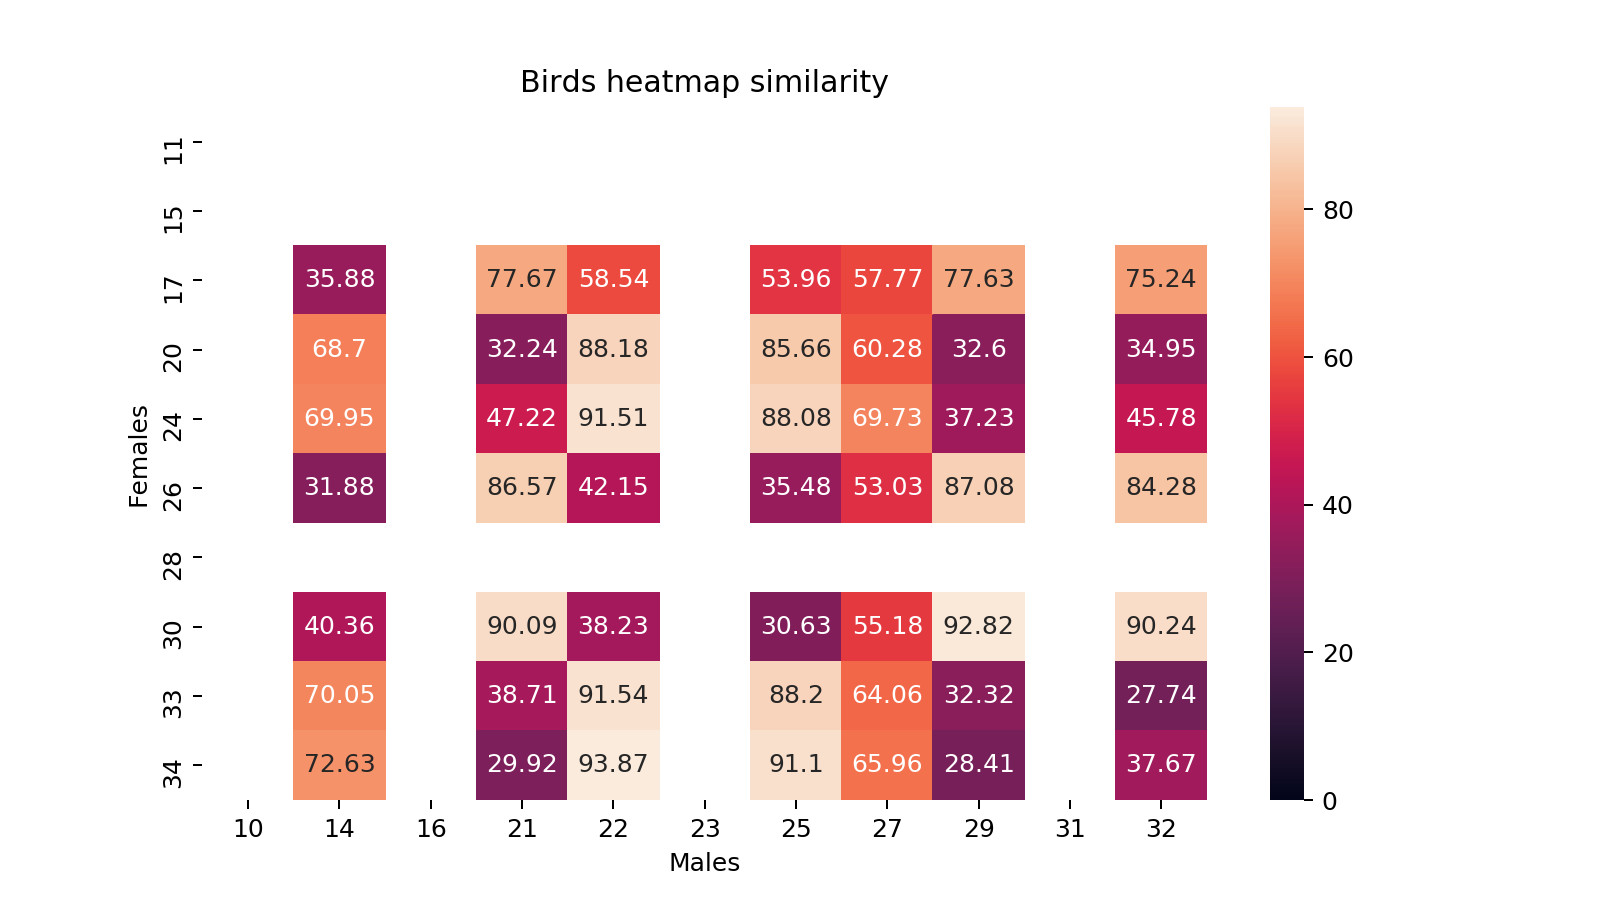

In [49]:
evaluate_similarity(birds_data, '2018-01-25 10:00:00', '2018-01-25 18:00:00')

In [17]:
def evaluate_similarity_all_days(birds_data):
    similarity_matrix_sum = np.zeros((len(FEMALES), len(MALES))) 
    similarity_matrix_count = np.zeros((len(FEMALES), len(MALES))) 
    for i in range(16):
        start_date = '2018-01-{} 09:00:00'.format(10+i)
        end_date = '2018-01-{} 18:00:00'.format(10+i)

        birds_data_in_date = birds_data[(start_date <= birds_data.timestamp) & (birds_data.timestamp < end_date)]
        similarity_matrix = get_heatmap_similarity(birds_data_in_date)
        similarity_matrix_sum = np.nansum([similarity_matrix_sum,similarity_matrix], axis=0)
        similarity_matrix_count = np.sum([similarity_matrix_count, (~np.isnan(similarity_matrix)).astype(int)], axis=0)
    similarity_matrix_mean = similarity_matrix_sum/similarity_matrix_count
    show_similarity_matrix(similarity_matrix_mean)
    show_similarity_matrix(similarity_matrix_count)
    

/Users/alew/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


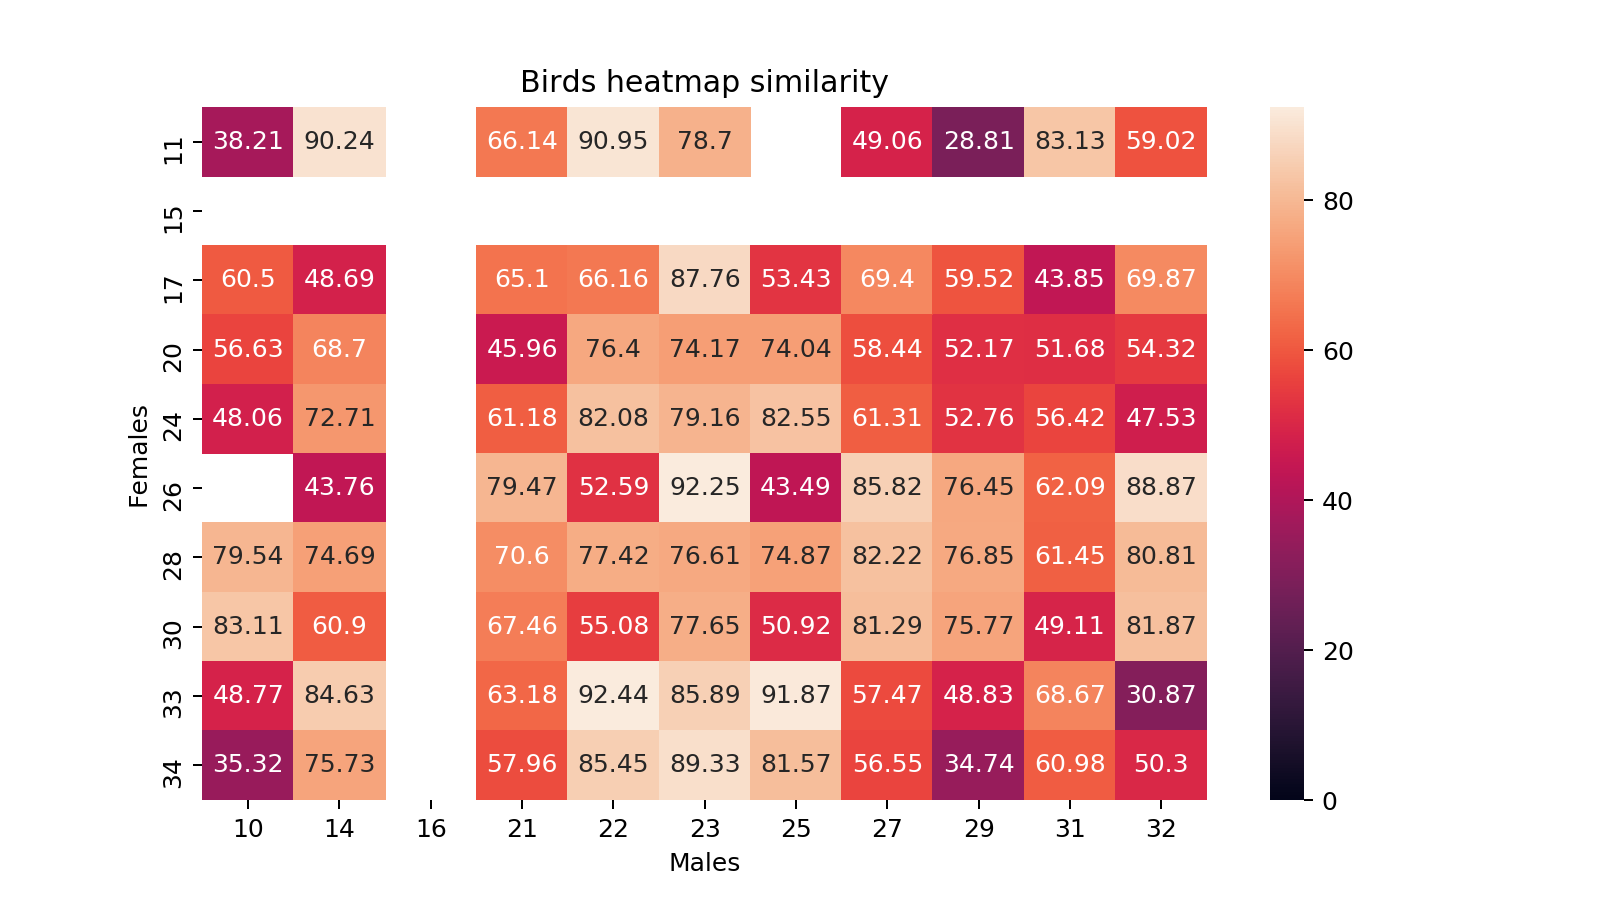

In [59]:
evaluate_similarity_all_days(birds_data)

/Users/alew/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


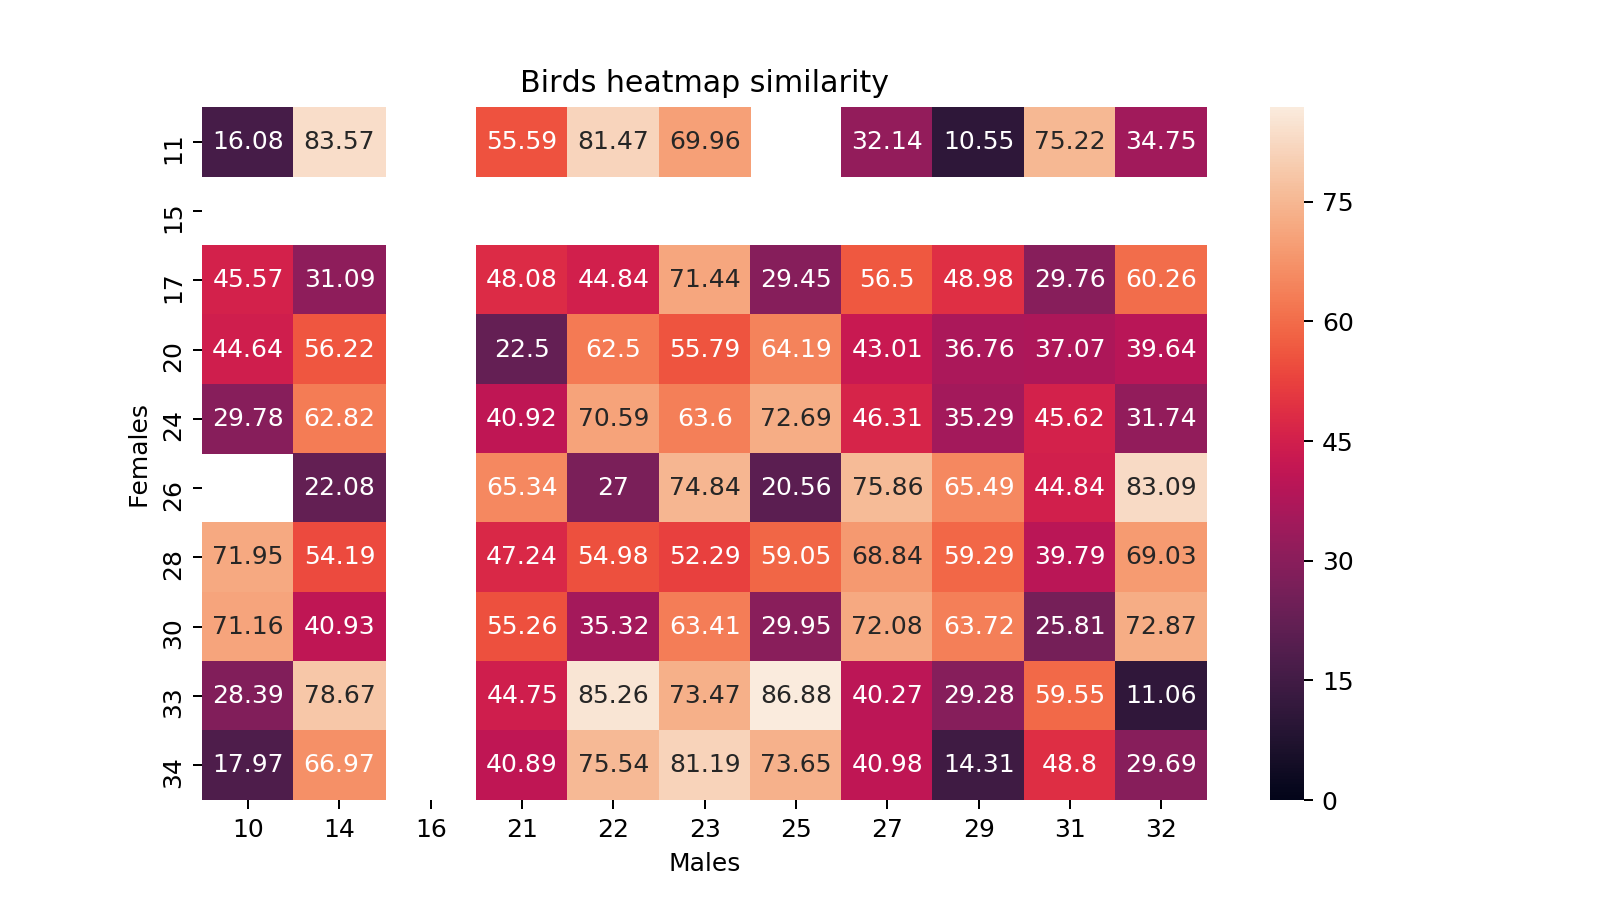

<IPython.core.display.Javascript object>


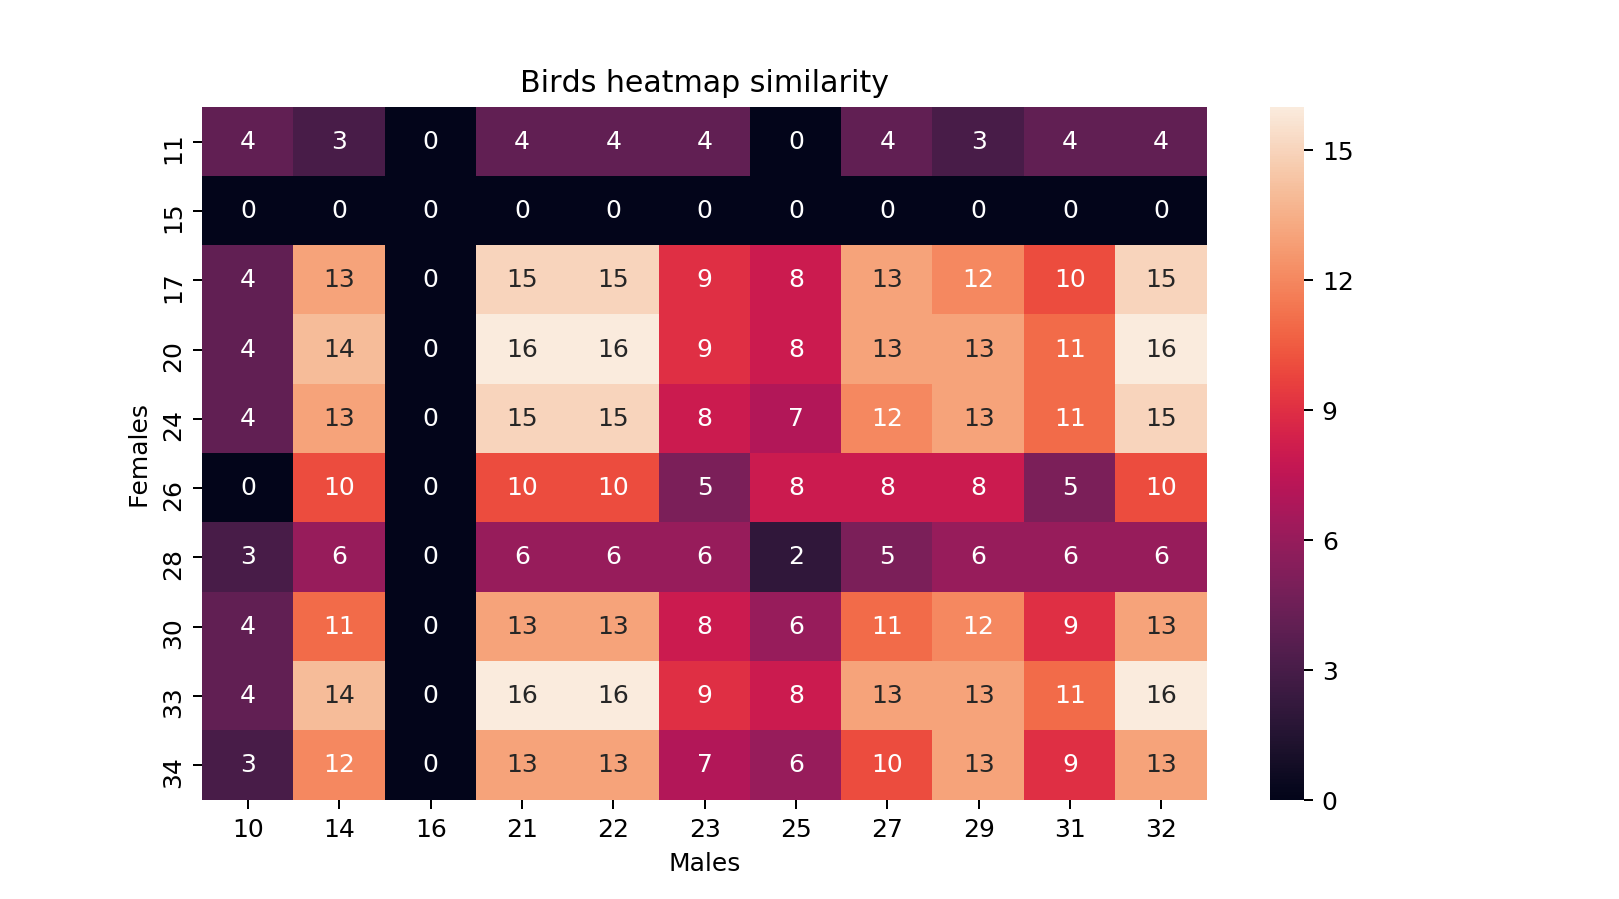

In [18]:
evaluate_similarity_all_days(birds_data)